In this notebook, we will be generating features to use for Deep-PIPE-Sites.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json

In [8]:
masks_path = "data/yeast_masks_singlesite_area_50_filtered.pkl"
uniprot_file = "data/uniprot-proteome UP000002311.tab"# reference proteome at https://www.uniprot.org/proteomes/UP000002311
pssm_path = "data/yeast_pssms/"

processed_data_path = "data/yeast_processed_norm_area_50/"
PIPE_dir = "data/PIPE_output/landscapes/yeast-yeast/"

# Find the max and min values across entire set and naively normoalize it with the assumption that the domain of the set is the domain of all possible data
NORM = True
LOAD_PARAMS = False
load_params_path = processed_data_path + 'min_maxes.json'

# Load data and masks

## Load masks

In [9]:
ppi_masks = pd.read_pickle(masks_path)
ppi_masks.head()

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks
0,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Q05471,Q12464,[PF00271],[PF06068],"[(1246, 1359)]","[(19, 362)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,P14682,P14682,[PF00179],[PF00179],"[(11, 164)]","[(11, 164)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
ppi_masks.shape

(1115, 7)

In [11]:
# All the protein sequences we need information for
proteins = ppi_masks['Uniprot ID A'].append(ppi_masks['Uniprot ID B'], ignore_index=True).unique()
proteins, proteins.shape

(array(['Q12188', 'P17065', 'P00546', ..., 'Q12045', 'P22219', 'P38080'],
       dtype=object),
 (1005,))

## Load sequences

In [12]:
uniprot_df = pd.read_csv(uniprot_file,
                        sep = "\t", index_col='Entry')
print("Loaded UniProt proteome")
uniprot_df

Loaded UniProt proteome


,Entry name,Status,Protein names,Gene names,Organism,Length,Sequence
Entry,,,,,,,
P21192,ACE2_YEAST,reviewed,Metallothionein expression activator,ACE2 YLR131C L3123 L9606.10,Saccharomyces cerevisiae (strain ATCC 204508 /...,770,MDNVVDPWYINPSGFAKDTQDEEYVQHHDNVNPTIPPPDNYILNNE...
P46993,ASG7_YEAST,reviewed,Protein ASG7 (A-specific gene 7 protein),ASG7 YJL170C J0514,Saccharomyces cerevisiae (strain ATCC 204508 /...,209,MTTLASSIEHKTKHLAAPFENDENPWMKKYCCQCKSCKMSVPVQPW...
P47117,ARP3_YEAST,reviewed,Actin-related protein 3 (Actin-like protein AR...,ARP3 ACT4 YJR065C J1760,Saccharomyces cerevisiae (strain ATCC 204508 /...,449,MSYLNNPAVVMDNGTGLTKLGFAGNDSPSWVFPTAIATAAPSNTKK...
P22768,ASSY_YEAST,reviewed,Argininosuccinate synthase (EC 6.3.4.5) (Citru...,ARG1 YOL058W O1228,Saccharomyces cerevisiae (strain ATCC 204508 /...,420,MSKGKVCLAYSGGLDTSVILAWLLDQGYEVVAFMANVGQEEDFDAA...
P29311,BMH1_YEAST,reviewed,Protein BMH1,BMH1 YER177W,Saccharomyces cerevisiae (strain ATCC 204508 /...,267,MSTSREDSVYLAKLAEQAERYEEMVENMKTVASSGQELSVEERNLL...
...,...,...,...,...,...,...,...
P47049,UBX6_YEAST,reviewed,UBX domain-containing protein 6,UBX6 YJL048C J1164,Saccharomyces cerevisiae (strain ATCC 204508 /...,396,MYEMSGIDSLFHDRVVHDYSHTSEQVIVVYISSAAGDNSWLHQWFK...
P53142,VPS73_YEAST,reviewed,Vacuolar protein sorting-associated protein 73,VPS73 YGL104C G3090,Saccharomyces cerevisiae (strain ATCC 204508 /...,486,MNRILSSASLLSNVSMPRQNKHKITKALCYAIIVASIGSIQFGYHL...
Q05919,VPS38_YEAST,reviewed,Vacuolar protein sorting-associated protein 38,VPS38 VPL17 YLR360W L8039.11,Saccharomyces cerevisiae (strain ATCC 204508 /...,439,MKRFLLSRRQRHLRMICFHNISLFRANGDSKLIKEYGDGFIPCFFI...


Create naive storage of min/max values for normalization

In [13]:
if NORM:
    if LOAD_PARAMS:
        with open(load_params_path, 'r') as f:
            min_maxes = json.load(f)
    else:
        min_maxes = {}
    
def update_min_max(min_val, max_val, mask):
    if np.max(mask) > max_val:
        max_val = np.max(mask)
    if np.min(mask) < min_val:
        min_val = np.min(mask)
        
    return min_val, max_val

def norm(min_val, max_val, mask_list):
    return [(mat - min_val) / (max_val - min_val) for mat in mask_list]

## ProtDCal

Generated using https://protdcal.zmb.uni-due.de/pages/form.php

## PSSMs

psiblast -query 'uniprot-proteome UP000002311.fasta' -db ~/sysc4906/s/swissprot -inclusion_ethresh 0.001 -num_iterations 2 -out_ascii_pssm yeast_filtered.pssm -save_pssm_after_last_round

/home/wma/sysc4906/ncbi-blast-2.11.0+/bin

for file in *.fasta; do echo "./runPsiBlast.sh '$file'"; done >> blastall.sh

rename -n 's/sp\|(.*?)\|.*/$1.pssm/' *

In [14]:
# psiblast -query .\output_sequences.fasta -db nr -out yeast_filtered_psiblast_out -evalue 0.001 -num_iterations 3 -out_pssm yeast_filtered_pssm_checkpoint -out_ascii_pssm yeast_filtered_pssm

In [15]:
AA = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

In [16]:
print("Loading PSSMs")
PSSMs = {}
for swissprot_id in proteins:
    pssm_A = pd.read_csv(pssm_path + swissprot_id + ".pssm", sep = "\s+", skiprows=2).reset_index()[AA].dropna()
    PSSMs[swissprot_id] = pssm_A.to_numpy()

Loading PSSMs


In [17]:
PSSM_masks = []

if NORM and not LOAD_PARAMS:
    max_val = np.NINF
    min_val = np.inf
print("Generating PSSM masks")
for UA, UB, SM in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B'], ppi_masks['Sites Masks']):
    try:        
        # number according to position    
        seqA = PSSMs[UA]
        seqB = PSSMs[UB]
        
        
        # Do a dot product for each 20 length vector along each position
        mask = np.matmul(seqA, seqB.T)
        
        assert SM.shape == mask.shape
        
        if NORM and not LOAD_PARAMS:
            min_val, max_val = update_min_max(min_val, max_val, mask)
            
        PSSM_masks.append(mask)
    except KeyError as inst:
        print(UA, UB)
        print(f"No uniprot entry found for protein {inst.args}")
        position_landscape.append(np.NaN)

Generating PSSM masks


In [18]:
# np.set_printoptions(threshold=1000)
PSSM_masks[:10]

[array([[174.,  68., 113., ...,  14., -17.,  60.],
        [ 84.,   9.,  73., ...,  38.,  18.,  33.],
        [ 80.,   4., 120., ...,  45.,  57.,  18.],
        ...,
        [172.,  49., 179., ...,  32., -15.,  92.],
        [ 57., 116.,  41., ...,  -8., -17.,  16.],
        [ 84.,   9.,  73., ...,  38.,  18.,  33.]]),
 array([[ 1.140e+02, -7.000e+00, -2.700e+01, ..., -4.000e+00,  5.400e+01,
          5.800e+01],
        [-7.000e+00,  6.300e+01,  9.100e+01, ...,  6.500e+01,  7.000e+01,
          7.500e+01],
        [ 1.300e+01,  1.212e+03,  2.560e+02, ...,  2.630e+02,  1.230e+02,
          7.000e+01],
        ...,
        [-1.000e+00,  4.600e+01,  6.900e+01, ...,  4.700e+01,  3.500e+01,
          3.700e+01],
        [ 1.800e+01,  3.300e+01,  5.700e+01, ...,  4.100e+01,  7.000e+00,
          9.000e+00],
        [ 1.800e+01,  3.300e+01,  5.700e+01, ...,  4.100e+01,  7.000e+00,
          9.000e+00]]),
 array([[164., -40.,   3., ..., -19., -17., 133.],
        [-17.,  64.,   6., ...,  65.,

In [19]:
if NORM:
    if LOAD_PARAMS:
        PSSM_masks = norm(min_maxes['PSSM'][0], min_maxes['PSSM'][1], PSSM_masks)
    else:
        PSSM_masks = norm(min_val, max_val, PSSM_masks)
        min_maxes['PSSM'] = (min_val, max_val)
        
    print(PSSM_masks[:10])

[array([[0.03280965, 0.02360906, 0.02751497, ..., 0.01892197, 0.01623123,
        0.02291468],
       [0.02499783, 0.01848798, 0.02404305, ..., 0.02100512, 0.01926916,
        0.02057113],
       [0.02465064, 0.01805399, 0.02812256, ..., 0.02161271, 0.02265428,
        0.01926916],
       ...,
       [0.03263606, 0.0219599 , 0.03324364, ..., 0.02048433, 0.01640483,
        0.02569221],
       [0.02265428, 0.02777537, 0.02126552, ..., 0.01701241, 0.01623123,
        0.01909556],
       [0.02499783, 0.01848798, 0.02404305, ..., 0.02100512, 0.01926916,
        0.02057113]]), array([[0.02760177, 0.01709921, 0.01536325, ..., 0.0173596 , 0.02239389,
        0.02274108],
       [0.01709921, 0.02317507, 0.02560542, ..., 0.02334867, 0.02378266,
        0.02421665],
       [0.01883517, 0.122906  , 0.03992709, ..., 0.04053468, 0.02838295,
        0.02378266],
       ...,
       [0.01762   , 0.02169951, 0.02369586, ..., 0.0217863 , 0.02074473,
        0.02091832],
       [0.01926916, 0.02057113, 0

In [20]:
ppi_masks['PSSM_masks'] = PSSM_masks
ppi_masks

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks
0,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.023609061713392936, 0..."
1,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.027601770679628504, 0.017099210138008854, ..."
2,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03194167172988456, 0.014234875444839857, 0..."
3,Q05471,Q12464,[PF00271],[PF06068],"[(1246, 1359)]","[(19, 362)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.026820588490582414, 0.017967190348060064, ..."
4,P14682,P14682,[PF00179],[PF00179],"[(11, 164)]","[(11, 164)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03168127766686919, 0.01848797847409079, 0...."
...,...,...,...,...,...,...,...,...
1110,P31244,P02294,[PF00176],[PF00125],"[(174, 520)]","[(1, 105)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.025258224112490235, 0.01840118045308567, 0..."
1111,P02294,P32558,[PF00125],[PF08512],"[(1, 105)]","[(835, 923)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028730144952695078, 0.01614443190695252, 0..."
1112,Q03750,Q12030,[PF10406],[PF03540],"[(174, 222)]","[(86, 135)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.015363249717906431, ..."
1113,P05626,P07251,[PF05405],[PF02874],"[(75, 237)]","[(62, 129)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024650637965454386, 0.022654283482336602, ..."


In [21]:
# clear from memory
del PSSM_masks

## Position

In [22]:
position_landscape = []
print("Generating position feature landscape")
for UA, UB, SM in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B'], ppi_masks['Sites Masks']):
    try:
        lengths = (uniprot_df['Length'].loc[UA], uniprot_df['Length'].loc[UB])
        
        # number according to position    
        seqA = np.arange(1, lengths[0]+1)[np.newaxis]
        seqB = np.arange(1, lengths[1]+1)[np.newaxis]
        
        # normalize
        seqA = np.divide(seqA, lengths[0])
        seqB = np.divide(seqB, lengths[1])
        
        mask = np.matmul(seqA.T, seqB)
        
        assert SM.shape == mask.shape
        
        position_landscape.append(mask)
    except KeyError as inst:
        print(UA, UB)
        print(f"No uniprot entry found for protein {inst.args}")
        position_landscape.append(np.NaN)
        
position_landscape = np.asarray(position_landscape)
print(lengths, mask.shape)

Generating position feature landscape
(186, 359) (186, 359)


C:\Users\mawil\Anaconda3\envs\SYSC4907\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
position_landscape[:2]

array([array([[1.19560019e-06, 2.39120038e-06, 3.58680057e-06, ...,
        1.46819703e-03, 1.46939264e-03, 1.47058824e-03],
       [2.39120038e-06, 4.78240077e-06, 7.17360115e-06, ...,
        2.93639407e-03, 2.93878527e-03, 2.94117647e-03],
       [3.58680057e-06, 7.17360115e-06, 1.07604017e-05, ...,
        4.40459110e-03, 4.40817791e-03, 4.41176471e-03],
       ...,
       [8.10616930e-04, 1.62123386e-03, 2.43185079e-03, ...,
        9.95437590e-01, 9.96248207e-01, 9.97058824e-01],
       [8.11812530e-04, 1.62362506e-03, 2.43543759e-03, ...,
        9.96905787e-01, 9.97717599e-01, 9.98529412e-01],
       [8.13008130e-04, 1.62601626e-03, 2.43902439e-03, ...,
        9.98373984e-01, 9.99186992e-01, 1.00000000e+00]]),
       array([[5.93478854e-06, 1.18695771e-05, 1.78043656e-05, ...,
        1.30565348e-03, 1.31158827e-03, 1.31752306e-03],
       [1.18695771e-05, 2.37391542e-05, 3.56087313e-05, ...,
        2.61130696e-03, 2.62317654e-03, 2.63504611e-03],
       [1.78043656e-05, 3.56

In [24]:
# # The data are already normalized from 0 to 1
# if NORM:
#     min_maxes['Position'] = (0,1)

In [25]:
ppi_masks['position_landscape'] = position_landscape
ppi_masks

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape
0,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.023609061713392936, 0...","[[1.1956001912960306e-06, 2.391200382592061e-0..."
1,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.027601770679628504, 0.017099210138008854, ...","[[5.934788543484196e-06, 1.1869577086968392e-0..."
2,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03194167172988456, 0.014234875444839857, 0...","[[6.145979300341716e-06, 1.2291958600683432e-0..."
3,Q05471,Q12464,[PF00271],[PF06068],"[(1246, 1359)]","[(19, 362)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.026820588490582414, 0.017967190348060064, ...","[[1.4023396634945744e-06, 2.8046793269891488e-..."
4,P14682,P14682,[PF00179],[PF00179],"[(11, 164)]","[(11, 164)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03168127766686919, 0.01848797847409079, 0....","[[1.1490950876185003e-05, 2.2981901752370006e-..."
...,...,...,...,...,...,...,...,...,...
1110,P31244,P02294,[PF00176],[PF00125],"[(174, 520)]","[(1, 105)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.025258224112490235, 0.01840118045308567, 0...","[[9.662769349695623e-06, 1.9325538699391246e-0..."
1111,P02294,P32558,[PF00125],[PF08512],"[(1, 105)]","[(835, 923)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028730144952695078, 0.01614443190695252, 0...","[[7.375447136482649e-06, 1.4750894272965298e-0..."
1112,Q03750,Q12030,[PF10406],[PF03540],"[(174, 222)]","[(86, 135)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.015363249717906431, ...","[[9.518370454978106e-06, 1.9036740909956212e-0..."
1113,P05626,P07251,[PF05405],[PF02874],"[(75, 237)]","[(62, 129)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024650637965454386, 0.022654283482336602, ...","[[7.519927808693037e-06, 1.5039855617386074e-0..."


In [26]:
# free from memory
del position_landscape

## PIPE

In [27]:
# Pandas is a little faster at file access and parsing than using Python

# import time

# PIPE_landscape = []
# PIPE_landscape_SW = []
# start = time.time()
# for protA, protB in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B']):
#     PIPE_landscape_name = protA + '-' + protB
    
#     # load PIPE landscape
#     with open(PIPE_dir + PIPE_landscape_name + '.mat', 'r') as PIPE_file:
#         pipe_lines = PIPE_file.readlines()
    
#     # Last row and column is a sum, we don't need that
#     # get rid of \n too
#     landscape = np.zeros((len(pipe_lines)-1, len(pipe_lines[0].split(' '))-2), dtype=np.float)
#     for j in range(len(pipe_lines)-1):
#         line = np.array(pipe_lines[j].split(' ')[:-2]) # last two are sum, \n respectively
#         line = line.astype(np.float)
        
#         landscape[j] = line
        
#     PIPE_landscape.append(landscape)
    
#     # load PIPE landscape, sw score adjusted
#     with open(PIPE_dir + PIPE_landscape_name + '_SW.mat', 'r') as PIPE_file:
#         pipe_lines = PIPE_file.readlines()
    
#     # Last row and column is a sum, we don't need that
#     # get rid of \n too
#     landscape = np.zeros((len(pipe_lines)-1, len(pipe_lines[0].split(' '))-2), dtype=np.float)
#     for j in range(len(pipe_lines)-1):
#         line = np.array(pipe_lines[j].split(' ')[:-2]) # last two are sum, \n respectively
#         line = line.astype(np.float)
        
#         landscape[j] = line
        
#     PIPE_landscape_SW.append(landscape)
    
# end = time.time()
    
# PIPE_landscape[89].shape, PIPE_landscape_SW[89].shape, ppi_masks.PSSM_masks.iloc[89].shape, end-start       

In [28]:
# import time
W = 20 # PIPE window size, PIPE matrix is smaller than protein sequence by W-1
pad = ((W-1) // 2, (W-1) - (W-1) //2)

if NORM and not LOAD_PARAMS:
    max_val = np.NINF
    min_val = np.inf
    max_val_sw = np.NINF
    min_val_sw = np.inf    
    
PIPE_landscape = []
PIPE_landscape_SW = []
# start = time.time()
for protA, protB in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B']):
    PIPE_landscape_name = protA + '-' + protB
    
    # load landscape
    landscape_df = pd.read_csv(PIPE_dir + PIPE_landscape_name + '.mat',
                               delim_whitespace=True,
                               header=None,
                               index_col=None)
    landscape = landscape_df.to_numpy().astype(np.float)
    landscape = np.pad(landscape[:-1, :-1], (pad, pad), 'minimum') # last row/column is a sum
    
    if NORM and not LOAD_PARAMS:
        min_val, max_val = update_min_max(min_val, max_val, landscape)
    
    PIPE_landscape.append(landscape) 
    
    # load sw landscape
    landscape_df = pd.read_csv(PIPE_dir + PIPE_landscape_name + '_SW.mat',
                               delim_whitespace=True,
                               header=None,
                               index_col=None)
    landscape = landscape_df.to_numpy().astype(np.float)
    landscape = np.pad(landscape[:-1, :-1], (pad, pad), 'minimum') # last row/column is a sum
    
    if NORM and not LOAD_PARAMS:
        min_val_sw, max_val_sw = update_min_max(min_val_sw, max_val_sw, landscape)
            
    PIPE_landscape_SW.append(landscape) # last row/column is a sum

# end = time.time()
PIPE_landscape[89].shape, PIPE_landscape_SW[89].shape, ppi_masks.PSSM_masks.iloc[89].shape #, end-start


((640, 217), (640, 217), (640, 217))

In [29]:
if NORM:
    if LOAD_PARAMS:
        PIPE_landscape = norm(min_maxes['PIPE'][0],  min_maxes['PIPE'][1], PIPE_landscape)
        PIPE_landscape_SW = norm(min_maxes['PIPE_sw'][0], min_maxes['PIPE_sw'][1], PIPE_landscape_SW)
    else:
        PIPE_landscape = norm(min_val, max_val, PIPE_landscape)
        PIPE_landscape_SW = norm(min_val_sw, max_val_sw, PIPE_landscape_SW)

        min_maxes['PIPE'] = (min_val, max_val)    
        min_maxes['PIPE_sw'] = (min_val_sw, max_val_sw)
    
    print(PIPE_landscape[:2])
    print(PIPE_landscape_SW[:2])

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
[array([[0.00035897, 0.00035897, 0.00035897, ..., 0.00035897, 0.00035897,
        0.00035897],
       [0.00035897, 0.00035897, 0.00035897, ..., 0.00035897, 0.00035897,
        0.00035897],
       [0.00035897, 0.00035897, 0.00035897, ..., 0.00035897, 0.00035897,
        0.00035897],
       ...,
       [0.00035897, 0.00035897, 0.00035897, ..., 0.00035897, 0.00035897,
        0.00035897],
       [0.00035897, 0.00035897, 0.00035897, ..., 0.00035897, 0.00035897,
        0.00035897],
       [0.00035897, 0.00035897, 

In [30]:
ppi_masks['PIPE_landscape'] = PIPE_landscape
ppi_masks['PIPE_landscape_SW'] = PIPE_landscape_SW
ppi_masks

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape,PIPE_landscape,PIPE_landscape_SW
0,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.023609061713392936, 0...","[[1.1956001912960306e-06, 2.391200382592061e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00035896824806535123, 0.000358968248065351..."
1,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.027601770679628504, 0.017099210138008854, ...","[[5.934788543484196e-06, 1.1869577086968392e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00048163514208694204, 0.000481635142086942..."
2,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03194167172988456, 0.014234875444839857, 0...","[[6.145979300341716e-06, 1.2291958600683432e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0011202288258748544, 0.0011202288258748544..."
3,Q05471,Q12464,[PF00271],[PF06068],"[(1246, 1359)]","[(19, 362)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.026820588490582414, 0.017967190348060064, ...","[[1.4023396634945744e-06, 2.8046793269891488e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0014557799487707585, 0.0014557799487707585..."
4,P14682,P14682,[PF00179],[PF00179],"[(11, 164)]","[(11, 164)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03168127766686919, 0.01848797847409079, 0....","[[1.1490950876185003e-05, 2.2981901752370006e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.2701571277798325e-05, 3.2701571277798325e-..."
...,...,...,...,...,...,...,...,...,...,...,...
1110,P31244,P02294,[PF00176],[PF00125],"[(174, 520)]","[(1, 105)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.025258224112490235, 0.01840118045308567, 0...","[[9.662769349695623e-06, 1.9325538699391246e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0007010486846882507, 0.0007010486846882507..."
1111,P02294,P32558,[PF00125],[PF08512],"[(1, 105)]","[(835, 923)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028730144952695078, 0.01614443190695252, 0...","[[7.375447136482649e-06, 1.4750894272965298e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0004810751151782092, 0.0004810751151782092..."
1112,Q03750,Q12030,[PF10406],[PF03540],"[(174, 222)]","[(86, 135)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.015363249717906431, ...","[[9.518370454978106e-06, 1.9036740909956212e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0003279067555916994, 0.0003279067555916994..."
1113,P05626,P07251,[PF05405],[PF02874],"[(75, 237)]","[(62, 129)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024650637965454386, 0.022654283482336602, ...","[[7.519927808693037e-06, 1.5039855617386074e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.003285441862196037, 0.003285441862196037, ..."


In [31]:
del PIPE_landscape
del PIPE_landscape_SW

## Prot2Vec

In [32]:
ppi_masks.iloc[839]

Uniprot ID A                                                     P02294
Uniprot ID B                                                     P53067
Domain_id_a                                                   [PF00125]
Domain_id_b                                                   [PF03810]
Domain positions A                                           [(1, 105)]
Domain positions B                                          [(21, 100)]
Sites Masks           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
PSSM_masks            [[0.028296154847669473, 0.015276451696901311, ...
position_landscape    [[7.603175085915878e-06, 1.5206350171831755e-0...
PIPE_landscape        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
PIPE_landscape_SW     [[0.000618647725404558, 0.000618647725404558, ...
Name: 839, dtype: object

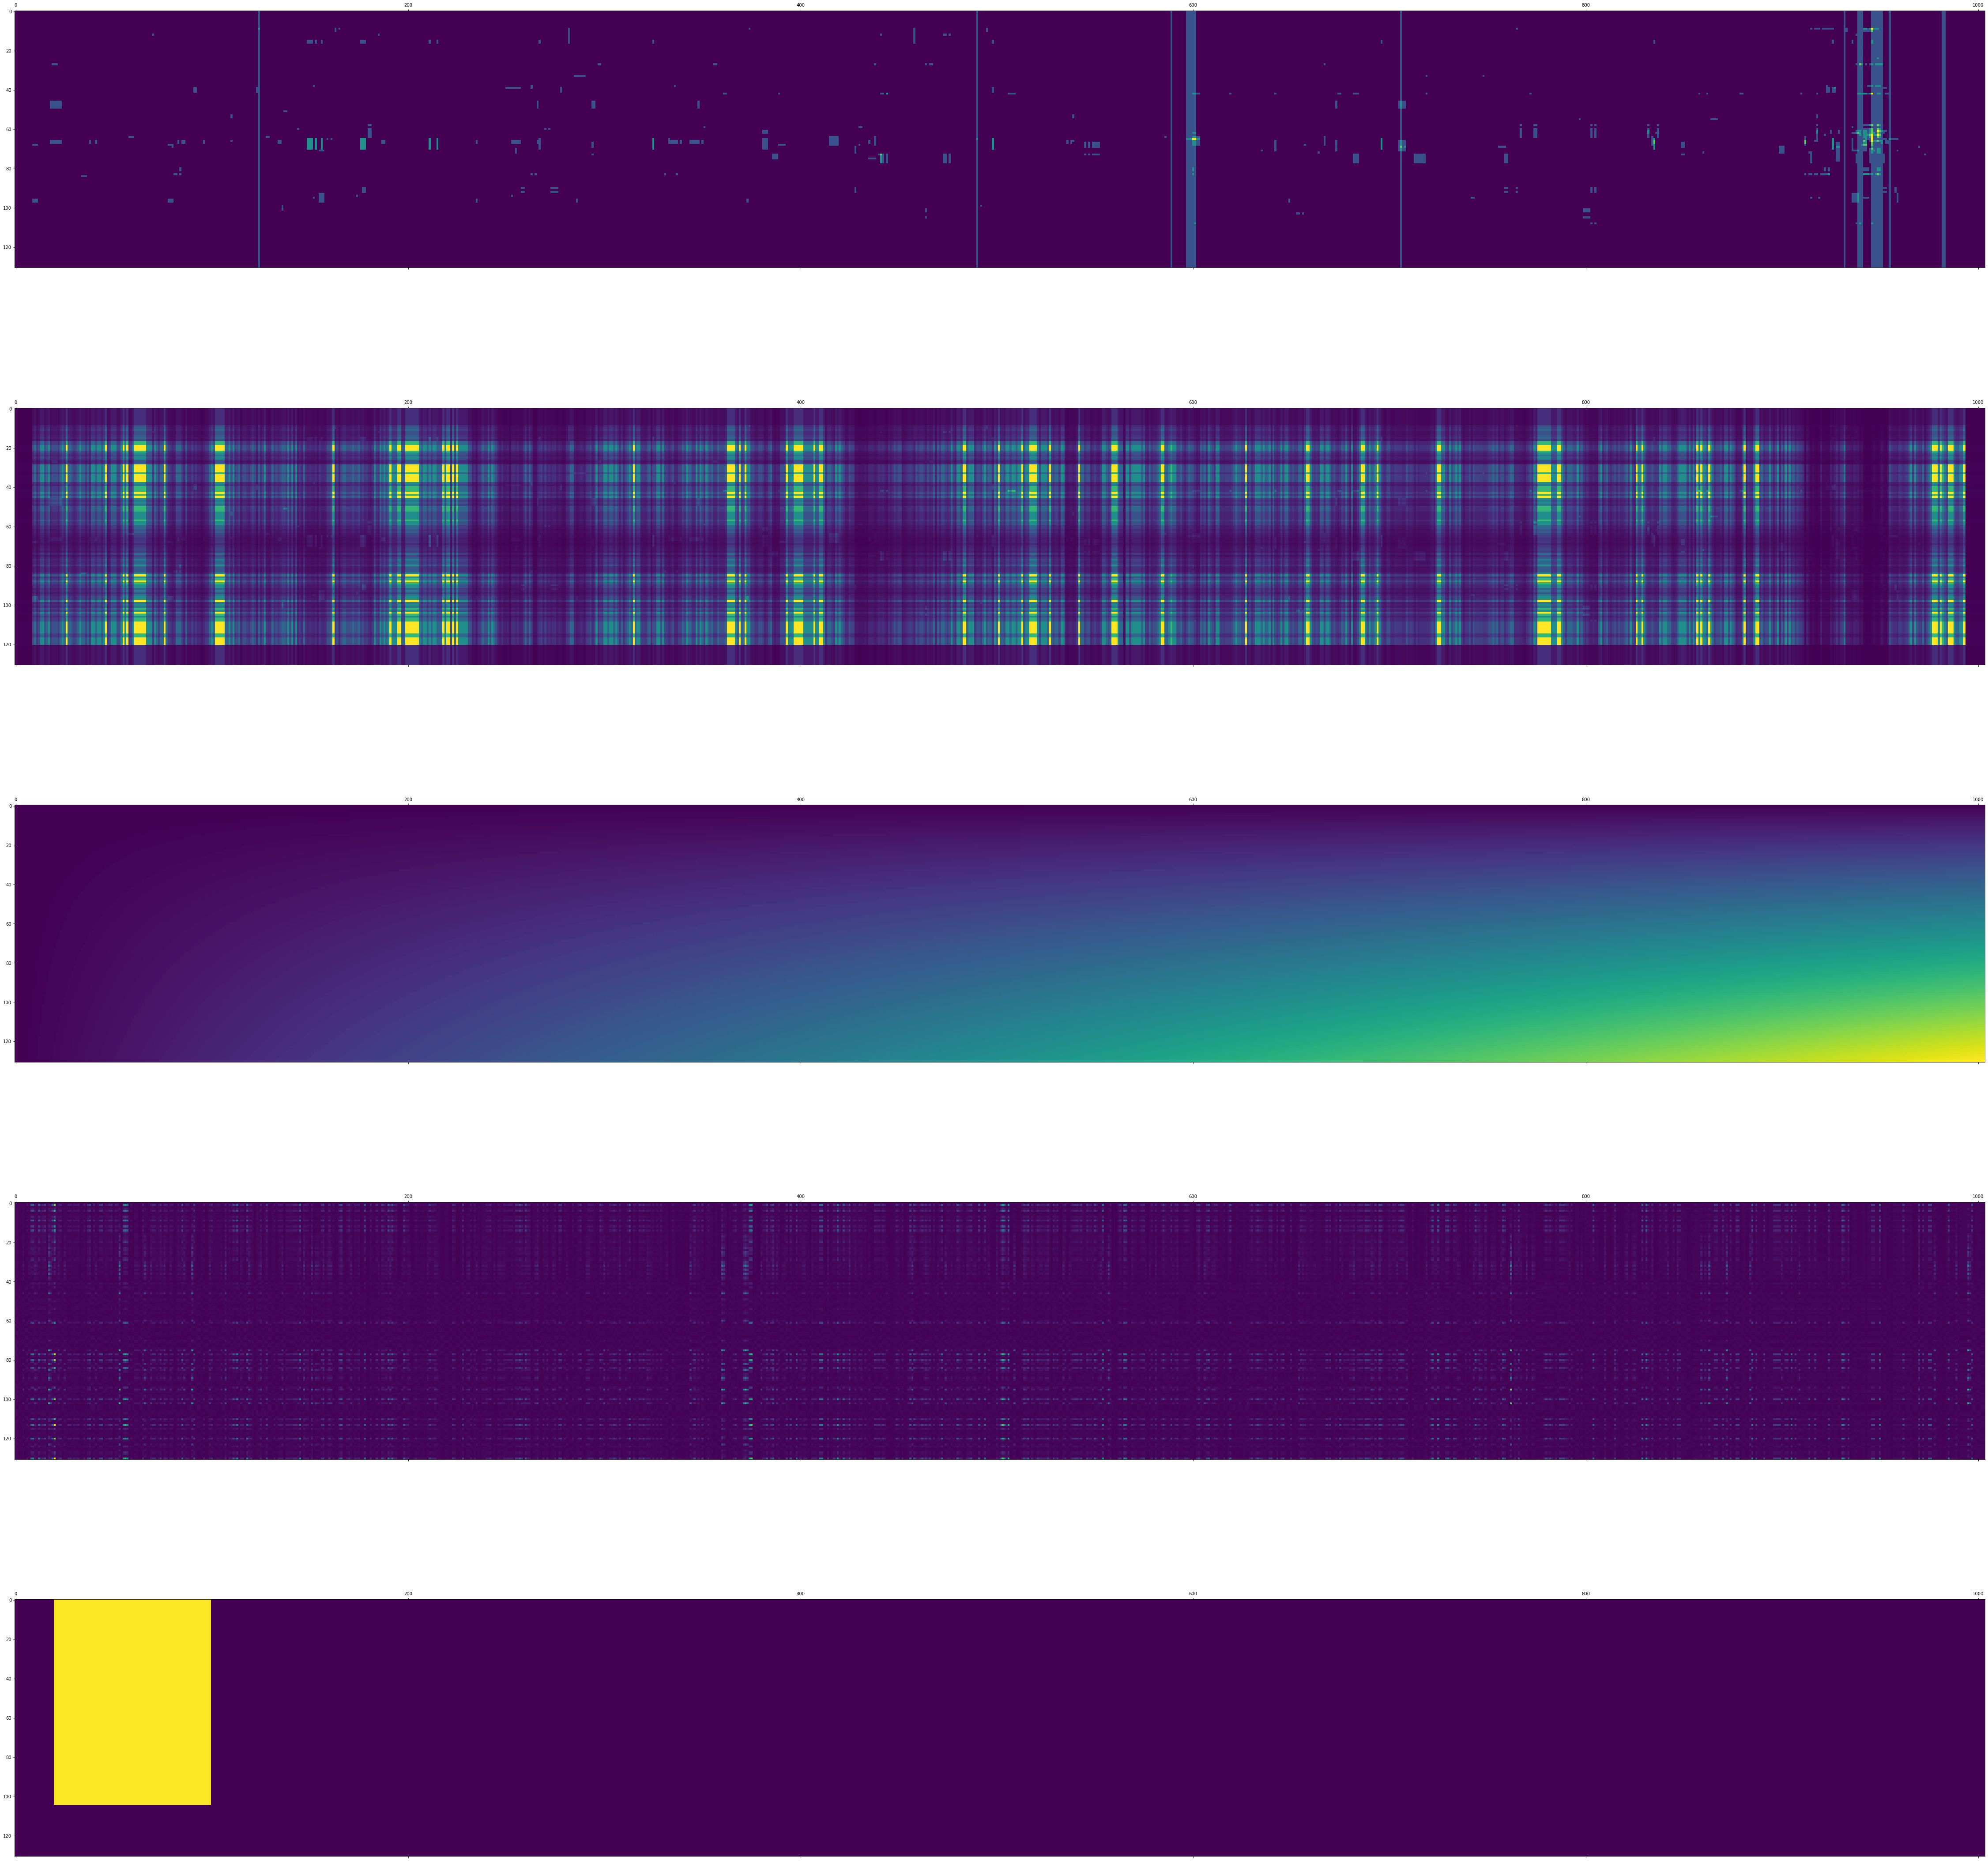

In [51]:
import matplotlib.pyplot as plt
query=839
fig, axs = plt.subplots(5, figsize=(80,80))
axs[0].matshow(ppi_masks.PIPE_landscape.iloc[query])
axs[1].matshow(ppi_masks.PIPE_landscape_SW.iloc[query])
axs[2].matshow(ppi_masks.position_landscape.iloc[query])
axs[3].matshow(ppi_masks.PSSM_masks.iloc[query])
axs[4].matshow(ppi_masks['Sites Masks'].iloc[query])
plt.show()

# Save

In [34]:
if not os.path.isdir(processed_data_path):
    os.mkdir(processed_data_path)

if NORM and not LOAD_PARAMS:
    print(min_maxes)
    
    with open(processed_data_path + 'min_maxes.json','w') as f:
        json.dump(min_maxes,f)

{'PSSM': (-204.0, 11317.0), 'PIPE': (1.0, 696.0), 'PIPE_sw': (0.048049, 1000.0)}


In [35]:
ppi_masks.to_pickle(processed_data_path + 'data_processed_2021-01-09.pkl')

## Open and save

In [36]:
ppi_masks = pd.read_pickle(processed_data_path + 'data_processed_2021-01-09.pkl')

In [37]:
from sklearn.model_selection import train_test_split
train_df, holdout_df = train_test_split(ppi_masks, test_size=0.2, random_state=86)
test_df, val_df = train_test_split(holdout_df, test_size=0.5, random_state=789)

In [38]:

# for UA, UB, site_mask, PSSM_mask, position_landscape in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B'], ppi_masks['Sites Masks'], ppi_masks['PSSM_masks'], ppi_masks['position_landscape']):
#     features = np.stack([PSSM_mask, position_landscape])
#     np.save(f'{processed_data_path}masks/{UA}_{UB}.npy', site_mask)
#     np.save(f'{processed_data_path}features/{UA}_{UB}.npy', features)


In [39]:
train_df

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape,PIPE_landscape,PIPE_landscape_SW
758,Q01649,P17119,[PF16796],[PF00225],"[(357, 494)]","[(392, 723)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.01623122992795764, 0...","[[2.3093301556950387e-06, 4.618660311390077e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0005306804986672805, 0.0005306804986672805..."
300,P32504,P32504,[PF16787],[PF16787],"[(185, 496)]","[(185, 496)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.01848797847409079, 0...","[[1.0941685194586928e-06, 2.1883370389173856e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[6.446509748346897e-05, 6.446509748346897e-05..."
370,P02294,P38144,[PF00125],[PF00176],"[(1, 105)]","[(169, 482)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02629980036455169, 0.01909556462112664, 0....","[[6.761370935570896e-06, 1.3522741871141793e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0008779191831388306, 0.0008779191831388306..."
1056,Q03338,P40018,[PF06544],[PF01423],"[(340, 467)]","[(10, 97)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02404305181841854, 0.015363249717906431, 0...","[[1.0878551847178102e-05, 2.1757103694356204e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00010762217113770098, 0.000107622171137700..."
931,P48240,P25359,[PF01138],[PF01138],"[(42, 186)]","[(48, 244)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.01900876660012152, 0...","[[1.015228426395939e-05, 2.030456852791878e-05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.002169350235109447, 0.002169350235109447, ..."
...,...,...,...,...,...,...,...,...,...,...,...
634,Q06169,Q03370,[PF06398],[PF06398],"[(58, 403)]","[(115, 465)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.014929259612880826, ...","[[3.4513463702190226e-06, 6.902692740438045e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0011481781688128332, 0.0011481781688128332..."
685,Q00772,P32491,[PF00069],[PF00069],"[(23, 318)]","[(214, 481)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.030639701414807742, 0.02005034285218297, 0...","[[4.083232613595531e-06, 8.166465227191062e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00017359034084228712, 0.000173590340842287..."
953,Q06506,Q02931,[PF00400],[PF00400],"[(225, 264)]","[(288, 325)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02560541619651072, 0.018921968579116395, 0...","[[1.9477686362503117e-06, 3.8955372725006235e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00021721343688842903, 0.000217213436888429..."
1001,P32902,Q03799,[PF00318],[PF00410],"[(188, 383)]","[(5, 154)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028209356826664353, 0.01900876660012152, 0...","[[1.6374652038644177e-05, 3.2749304077288354e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.006445766712644776, 0.006445766712644776, ..."


In [40]:
test_df

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape,PIPE_landscape,PIPE_landscape_SW
787,P27515,Q12084,[PF00485],[PF00485],"[(58, 247)]","[(25, 181)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.025431820154500476, 0.015797239822932036, ...","[[8.603482689792828e-06, 1.7206965379585656e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0014335008782837006, 0.0014335008782837006..."
644,P32602,Q12241,[PF14938],[PF05739],"[(2, 285)]","[(226, 278)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028296154847669473, 0.016404825969967885, ...","[[1.2101263371896025e-05, 2.420252674379205e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00015670852968814296, 0.000156708529688142..."
864,P32628,Q01939,[PF00240],[PF00004],"[(4, 75)]","[(185, 318)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028296154847669473, 0.019442756705147123, ...","[[6.203858800173708e-06, 1.2407717600347417e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0008361641768525335, 0.0008361641768525335..."
401,P22276,P20435,[PF04560],[PF01192],"[(1058, 1144)]","[(79, 132)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024563839944449266, 0.01623122992795764, 0...","[[5.614980768690867e-06, 1.1229961537381735e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.003424337535994267, 0.003424337535994267, ..."
505,P38336,P40993,[PF01868],[PF04032],"[(171, 263)]","[(17, 110)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.015363249717906431, ...","[[1.810216863980305e-05, 3.62043372796061e-05,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0019361710310818723, 0.0019361710310818723..."
...,...,...,...,...,...,...,...,...,...,...,...
247,P40568,Q12143,[PF08202],[PF08641],"[(223, 572)]","[(62, 195)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.01683881607499349, 0...","[[8.037551440329217e-06, 1.6075102880658434e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00029094797975947944, 0.000290947979759479..."
956,P38789,Q06511,[PF04427],[PF07890],"[(34, 341)]","[(102, 242)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02412984983942366, 0.017099210138008854, 0...","[[8.830022075055188e-06, 1.7660044150110377e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0005035471949391696, 0.0005035471949391696..."
0,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.023609061713392936, 0...","[[1.1956001912960306e-06, 2.391200382592061e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00035896824806535123, 0.000358968248065351..."
929,Q12438,Q12438,[PF00462],[PF00462],"[(128, 193)]","[(128, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023609061713392936, 0.02334866765037757, 0...","[[1.874027848053822e-05, 3.748055696107644e-05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0038737061277057307, 0.0038737061277057307..."


In [41]:
val_df

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape,PIPE_landscape,PIPE_landscape_SW
482,P12695,P16387,[PF00198],[PF00676],"[(248, 482)]","[(86, 382)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.023869455776408297, ...","[[4.939735230191662e-06, 9.879470460383324e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0008779191831388306, 0.0008779191831388306..."
457,P38806,P43572,[PF12998],[PF10513],"[(6, 111)]","[(56, 199)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02569221421751584, 0.017967190348060064, 0...","[[4.2621385706492094e-06, 8.524277141298419e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0006304072904398983, 0.0006304072904398983..."
773,P32609,P36017,[PF11464],[PF00071],"[(464, 505)]","[(9, 173)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03150768162485895, 0.014929259612880826, 0...","[[9.246417013407305e-06, 1.849283402681461e-05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0008677436942167634, 0.0008677436942167634..."
340,P51996,P19524,[PF00071],[PF01843],"[(15, 176)]","[(1382, 1482)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03194167172988456, 0.01840118045308567, 0....","[[2.861819888503497e-06, 5.723639777006994e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0016836338969251135, 0.0016836338969251135..."
156,P16370,P08518,[PF01193],[PF00562],"[(19, 255)]","[(752, 1124)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028296154847669473, 0.01597083586494228, 0...","[[2.569161836642414e-06, 5.138323673284828e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0019051675413951964, 0.0019051675413951964..."
...,...,...,...,...,...,...,...,...,...,...,...
514,P38932,Q08144,[PF00995],[PF05739],"[(33, 572)]","[(280, 332)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024650637965454386, 0.021612707230275148, ...","[[4.365496859025009e-06, 8.730993718050018e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0005175868695314941, 0.0005175868695314941..."
492,P32628,P14736,[PF09280],[PF03835],"[(260, 309)]","[(284, 426)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024650637965454386, 0.014582067528860342, ...","[[3.3323114244964877e-06, 6.6646228489929754e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0002536221862924292, 0.0002536221862924292..."
1048,P32617,Q12464,[PF08265],[PF06068],"[(115, 143)]","[(19, 362)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.025171426091485115, 0.0177067962850447, 0....","[[1.2790013557414371e-05, 2.5580027114828743e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0009181791175884211, 0.0009181791175884211..."
269,P38798,P30771,[PF04050],[PF09416],"[(950, 1085)]","[(60, 208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.023088273587362207, ...","[[9.456989140539369e-07, 1.8913978281078738e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00017351733733454158, 0.000173517337334541..."


In [42]:
if not os.path.isdir(processed_data_path + 'train/'):
    os.mkdir(processed_data_path + 'train/')
if not os.path.isdir(processed_data_path + 'test/'):
    os.mkdir(processed_data_path + 'test/')
if not os.path.isdir(processed_data_path + 'val/'):
    os.mkdir(processed_data_path + 'val/')

if not os.path.isdir(processed_data_path + 'train/masks/'):
    os.mkdir(processed_data_path + 'train/masks/')
if not os.path.isdir(processed_data_path + 'test/masks/'):
    os.mkdir(processed_data_path + 'test/masks/')
if not os.path.isdir(processed_data_path + 'val/masks/'):
    os.mkdir(processed_data_path + 'val/masks/')
if not os.path.isdir(processed_data_path + 'train/features/'):
    os.mkdir(processed_data_path + 'train/features/')
if not os.path.isdir(processed_data_path + 'test/features/'):
    os.mkdir(processed_data_path + 'test/features/')
if not os.path.isdir(processed_data_path + 'val/features/'):
    os.mkdir(processed_data_path + 'val/features/')


for UA, UB, site_mask, PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW in zip(test_df['Uniprot ID A'], 
                                                                                                test_df['Uniprot ID B'], 
                                                                                                test_df['Sites Masks'], 
                                                                                                test_df['PSSM_masks'], 
                                                                                                test_df['position_landscape'],
                                                                                                test_df['PIPE_landscape'],
                                                                                                test_df['PIPE_landscape_SW']):
    features = np.stack([PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW])
    np.save(f'{processed_data_path}test/masks/{UA}_{UB}.npy', np.expand_dims(site_mask, axis=0))
    np.save(f'{processed_data_path}test/features/{UA}_{UB}.npy', features)

In [43]:
for UA, UB, site_mask, PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW in zip(val_df['Uniprot ID A'], 
                                                                                                val_df['Uniprot ID B'], 
                                                                                                val_df['Sites Masks'], 
                                                                                                val_df['PSSM_masks'], 
                                                                                                val_df['position_landscape'],
                                                                                                val_df['PIPE_landscape'],
                                                                                                val_df['PIPE_landscape_SW']):
    features = np.stack([PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW])
    np.save(f'{processed_data_path}val/masks/{UA}_{UB}.npy', np.expand_dims(site_mask, axis=0))
    np.save(f'{processed_data_path}val/features/{UA}_{UB}.npy', features)

In [44]:


for UA, UB, site_mask, PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW in zip(train_df['Uniprot ID A'], 
                                                                                                train_df['Uniprot ID B'], 
                                                                                                train_df['Sites Masks'], 
                                                                                                train_df['PSSM_masks'], 
                                                                                                train_df['position_landscape'],
                                                                                                train_df['PIPE_landscape'],
                                                                                                train_df['PIPE_landscape_SW']):
    features = np.stack([PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW])
    np.save(f'{processed_data_path}train/masks/{UA}_{UB}.npy', np.expand_dims(site_mask, axis=0))
    np.save(f'{processed_data_path}train/features/{UA}_{UB}.npy', features)

In [45]:
np.expand_dims(test_df['Sites Masks'].iloc[0], axis=0)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [46]:
train_df.to_pickle(processed_data_path + 'train.pkl')
test_df.to_pickle(processed_data_path + 'test.pkl')
val_df.to_pickle(processed_data_path + 'val.pkl')

## Create json of just bounding box labels

In [47]:
train_df = pd.read_pickle(processed_data_path + 'train.pkl')
test_df = pd.read_pickle(processed_data_path + 'test.pkl')
val_df = pd.read_pickle(processed_data_path + 'val.pkl')

train_coords = {}
test_coords = {}
val_coords = {}
for UA, UB, DPA, DPB in zip(test_df['Uniprot ID A'], 
                            test_df['Uniprot ID B'], 
                            test_df['Domain positions A'], 
                            test_df['Domain positions B']):
    test_coords[f'{UA}_{UB}'] = DPA + DPB
    
for UA, UB, DPA, DPB in zip(train_df['Uniprot ID A'], 
                            train_df['Uniprot ID B'], 
                            train_df['Domain positions A'], 
                            train_df['Domain positions B']):
    train_coords[f'{UA}_{UB}'] = DPA + DPB
    
for UA, UB, DPA, DPB in zip(val_df['Uniprot ID A'], 
                            val_df['Uniprot ID B'], 
                            val_df['Domain positions A'], 
                            val_df['Domain positions B']):
    val_coords[f'{UA}_{UB}'] = DPA + DPB
test_coords

{'P27515_Q12084': [(58, 247), (25, 181)],
 'P32602_Q12241': [(2, 285), (226, 278)],
 'P32628_Q01939': [(4, 75), (185, 318)],
 'P22276_P20435': [(1058, 1144), (79, 132)],
 'P38336_P40993': [(171, 263), (17, 110)],
 'Q01590_P38736': [(285, 337), (136, 201)],
 'Q00764_P38426': [(16, 482), (286, 765)],
 'Q08920_P53617': [(48, 118), (341, 400)],
 'P38987_P27636': [(22, 187), (25, 272)],
 'Q08932_P39990': [(224, 274), (18, 112)],
 'P36017_P54787': [(9, 173), (206, 308)],
 'Q07540_Q03020': [(68, 174), (34, 161)],
 'Q12223_Q12223': [(47, 201), (47, 201)],
 'P47093_P40089': [(3, 66), (10, 83)],
 'Q12446_P60010': [(544, 574), (2, 375)],
 'P40479_P36005': [(68, 193), (23, 318)],
 'P53082_Q03835': [(6, 114), (163, 227)],
 'P33328_Q04338': [(24, 112), (125, 190)],
 'P25638_P25638': [(14, 80), (14, 80)],
 'P32490_Q00772': [(221, 488), (23, 318)],
 'P53905_P38203': [(28, 104), (5, 72)],
 'Q08963_Q06217': [(47, 181), (37, 106)],
 'P08964_Q12280': [(77, 779), (718, 738)],
 'P43573_P43573': [(8, 126), (

In [48]:
# json doesn't like numpy
def convert(o):
    if isinstance(o, np.int32): return int(o)  
    raise TypeError
    
with open(processed_data_path + 'test_coords.json','w') as f:
    json.dump(test_coords,f, default=convert)
with open(processed_data_path + 'train_coords.json','w') as f:
    json.dump(train_coords,f, default=convert)
with open(processed_data_path + 'val_coords.json','w') as f:
    json.dump(val_coords,f, default=convert)

In [50]:
type(test_coords['P20459_P14741'][0][0])

numpy.int32